In this tutorial, we’ll explore various ways to simulate two-dimensional heat diffusion using Python.

We'll be testing four different methods. Along the way, we’ll compare their performance and see how parallel computing with JAX and just-in-time compilation can make a real difference.

Let's get started!

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import time
import jax
import jax.numpy as jnp
import inspect
import pandas as pd
from heat_equation import (
    get_A, advance_time_matvecmul,
    get_sparse_A, advance_time_matvecmul_sparse,
    advance_time_numpy, advance_time_jax
)

## Heat Equation

Quite intuitively, when one part of an object is hotter than its surrounding, thermal energy would flow from high-temperature areas to low-temperature areas. The mathematical model that describes this process of heat diffusion in 2D is the **heat equation**:

$$\frac{\partial f(x,t)}{\partial t} = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2}.$$

In a discrete approximation, we can put:

$$x_i = i\Delta x, \quad y_j = j\Delta y, \quad t_k = k\Delta t,$$

for $i, j = 0, 1, 2, ..., N-1$ and $k = 0, 1, 2, ...$.

When we define temperature as $u_{i,j}^k = f(x_i, y_j, t_k)$, the discretized update equation would become:

$$u_{i,j}^{k+1} \approx u_{i,j}^k + \epsilon (u_{i+1,j}^k + u_{i-1,j}^k + u_{i,j+1}^k + u_{i,j-1}^k - 4u_{i,j}^k)$$

where $\epsilon$ is a small parameter that controls stability. For the boundary condition, we can construct it to allow heat to escape:

$$u_{-1,j}^k = u_{N,j}^k = u_{i,-1}^k = u_{i,N}^k = 0.$$



Let's set up some common parameters and helper functions for our visualizations:

In [7]:
# Simulation parameters
N = 101
epsilon = 0.2
iterations = 2700  # Number of time steps
interval = 300  # Store solution every 300 iterations

def vis_sim(s):
    """Visualizes heat diffusion simulation on a 3x3 grid."""
    plt.figure(figsize=(15, 15))
    for i, s in enumerate(s):
        plt.subplot(3, 3, i+1)
        plt.imshow(s, cmap='viridis')
        plt.title(f"Iteration {(i+1) * interval}")

    plt.show()

def get_init_condition(N):
    """Creates the initial condition by putting 1 unit of heat at the midpoint."""
    u0 = np.zeros((N, N))
    u0[int(N/2), int(N/2)] = 1.0
    return u0

## Simulating the Heat Equation

### Matrix-vector multiplication

Our first approach will represent heat diffusion in the 2D space as a matrix-vector multiplication. 

We will create a reate a matrix $A$ of size $N^2 \times N^2$. Here's the implementation of constructing the matrix:

In [11]:
print(inspect.getsource(get_A))

def get_A(N):
    """
    Args:
        N: Number of grid points in each dimension.

    Returns:
        A: 2D finite difference matrix.
    """
    n = N * N
    diagonals = [-4 * np.ones(n), np.ones(n-1), np.ones(n-1), np.ones(n-N), np.ones(n-N)]
    
    # Set boundary conditions
    diagonals[1][(N-1)::N] = 0
    diagonals[2][(N-1)::N] = 0

    A = np.diag(diagonals[0])  # Main diagonal
    A += np.diag(diagonals[1], 1) +  np.diag(diagonals[2], -1) # right and left neighbor
    A += np.diag(diagonals[3], N) +  np.diag(diagonals[4], -N) # bottom and top neighbor
    
    return A



With this matrix, we can advance the simulation by one time step:

In [13]:
print(inspect.getsource(advance_time_matvecmul))

def advance_time_matvecmul(A, u, epsilon):
    """Advances the simulation by one timestep using matrix-vector multiplication.
    Args:
        A: 2D finite difference matrix. 
        u: N x N grid state at timestep k.
        epsilon: stability constant.

    Returns:
        N x N Grid state at timestep k+1.
    """
    N = u.shape[0]
    u = u + epsilon * (A @ u.flatten()).reshape((N, N))
    return u



This function flattens the 2D temperature grid into a 1D vector and multiplies it by matrix $A$. After reshaping the result back to 2D grid, the temperature values are updated according to our update equation.

20.11 seconds for 2700 iterations


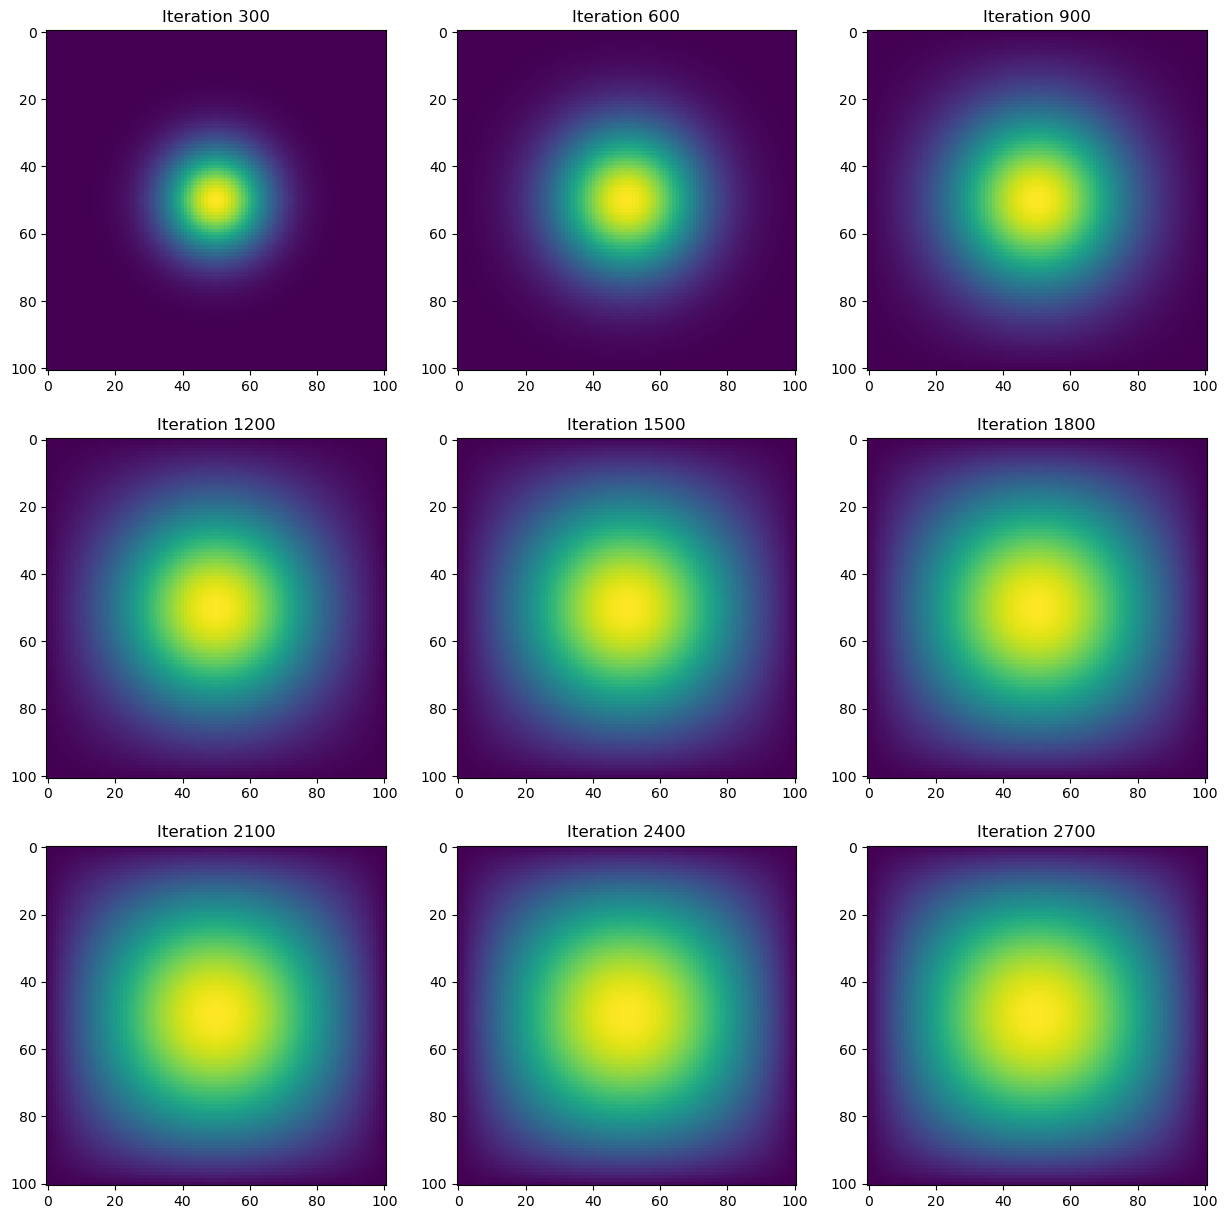

In [15]:
def sim_heat_diffusion_matvecmul(N, epsilon, iterations, interval):
    """Simulates heat diffusion using matrix-vector multiplication."""
    # Initialize the grid
    u = get_init_condition(N)
    
    # Get the matrix
    A = get_A(N)
    
    # Store simulation at specified intervals
    sims = []
    
    # Run the simulation and measure time
    start_time = time.time()

    for i in range(1, iterations + 1):
        u = advance_time_matvecmul(A, u, epsilon)

        # Store intermediate solution
        if i % interval == 0:
            sims.append(u.copy())
    
    end_time = time.time()
    comp_time = end_time - start_time
    print(f"{comp_time:.2f} seconds for {iterations} iterations")
    
    return comp_time, sims

time_matvecmul, sims_matvecmul = sim_heat_diffusion_matvecmul(N, epsilon, iterations, interval)
vis_sim(sims_matvecmul)

As you can see, this matrix multiplication approach is pretty slow. It is conceptually straightforward, as it follows directly from the mathematical formulation. However, most elements of $A$ are zero, so many operations in the matrix-vector multiplication are  redundant, which leads to relatively low computational efficiency.

### Sparse matrix in JAX

Instead of having operations wasted for computing zeros, we can use the data structure that exploits a lot of zeros in $A$, i.e., sparse matrix data structures.

Rather than storing all $N^4$ elements (most of which are zero!), we will only store the non-zero elements and their positions:

In [19]:
print(inspect.getsource(get_sparse_A))

def get_sparse_A(N):
    """
    Args:
        N: Number of grid points in each dimension.  

    Returns:
        A_sp_matrix: Sparse 2D finite difference matrix in BCOO format.
    """
    n = N * N
    rows, cols, values = [], [], []  # Initialize lists to store nonzero entries
    
    for i in range(n):
        rows.append(i)
        cols.append(i)
        values.append(-4)  # Main diagonal
        
        # Left neighbor
        if i % N != 0:
            rows.append(i)
            cols.append(i - 1)
            values.append(1)
        
        # Right neighbor
        if (i + 1) % N != 0:
            rows.append(i)
            cols.append(i + 1)
            values.append(1)
        
        # Top neighbor
        if i >= N:
            rows.append(i)
            cols.append(i - N)
            values.append(1)
        
        # Bottom neighbor
        if i < n - N:
            rows.append(i)
            cols.append(i + N)
            values.append(1)
    
    # Convert lists t

The sparse approach only stores the non-zero elements of the matrix and their positions. And it can be very effective in drastically reducing memory usage. Based on this, we can use JAX's just-in-time compilation to accelerate the computation.

In [21]:
print(inspect.getsource(advance_time_matvecmul_sparse))

@jax.jit
def advance_time_matvecmul_sparse(A_sp, u_flat, epsilon):
    """Advances the simulation by one timestep using sparse matrix-vector multiplication
    Args:
        A_sp: Sparse 2D finite difference matrix. 
        u_flat: Flattened N x N grid state at timestep k.
        epsilon: Stability constant.

    Returns:
        Flattened grid state at timestep k+1.
    """
    return u_flat + epsilon * (A_sp @ u_flat)



The `@jax.jit` decorator compiles this function into optimized machine code, and can thus provide significant speedups.

0.76 seconds for 2700 iterations


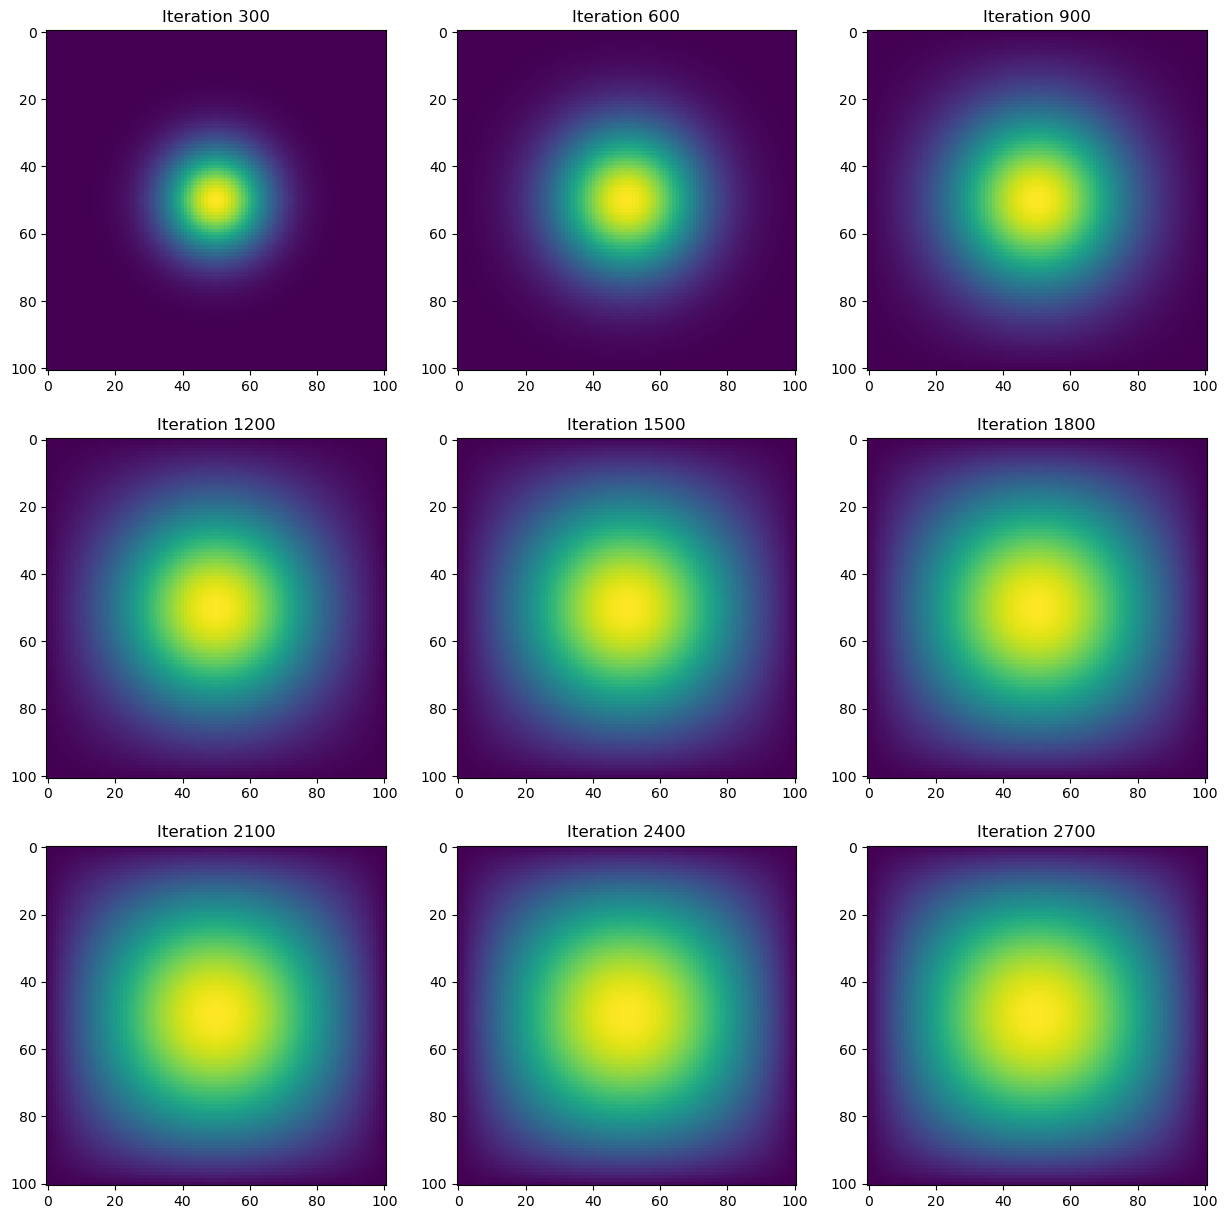

In [23]:
def sim_heat_diffusion_sparse(N, epsilon, iterations, interval):
    """Simulates heat diffusion using sparse matrix multiplication with JAX."""

    u = get_init_condition(N)
    
    # Convert to JAX arrays and flatten for sparse matrix operations
    u_flat = jnp.array(u.flatten())
    
    A_sp = get_sparse_A(N)
    
    sims = []

    start_time = time.time()
    
    for i in range(1, iterations + 1):
        u_flat = advance_time_matvecmul_sparse(A_sp, u_flat, epsilon)
 
        if i % interval == 0:
            # Convert back to numpy
            u_reshaped = np.array(u_flat).reshape((N, N))
            sims.append(u_reshaped.copy())
    
    end_time = time.time()
    comp_time = end_time - start_time
    print(f"{comp_time:.2f} seconds for {iterations} iterations")
    
    return comp_time, sims

time_sparse, sims_sparse = sim_heat_diffusion_sparse(N, epsilon, iterations, interval)
vis_sim(sims_sparse)

This is impressive! It is significantly faster than that using the first approach. With the sparse matrix, the batched coordinate (BCOO) format allows us to only use $O(N^2)$ space for the matrix and take only $O(N^2)$ time for each update. Moreover, JIT has also enabled us to run the computation faster through JAX's optimization.

### Direct operation with numpy

What if we didn’t need matrices at all? In this case, we can skip them entirely! By using vectorized array operations, we can simplify the computation even further. Let’s see how we can make this work using `numpy`:

In [27]:
print(inspect.getsource(advance_time_numpy))

def advance_time_numpy(u, epsilon):
    """Advances the simulation by one timestep using direct NumPy operations.  
    Args:
        u: N x N grid state at timestep k.
        epsilon: Stability constant.
        
    Returns:
        N x N Grid state at timestep k+1.
    """
    u_down = np.roll(u, -1, axis=0)  # Shift down (i+1, j)
    u_up = np.roll(u, 1, axis=0)     # Shift up (i-1, j)
    u_right = np.roll(u, -1, axis=1) # Shift right (i, j+1)
    u_left = np.roll(u, 1, axis=1)   # Shift left (i, j-1)
    
    # Apply zero boundary conditions
    u_down[-1, :] = 0  # bottom boundary
    u_up[0, :] = 0 
    u_right[:, -1] = 0 # right boundary
    u_left[:, 0] = 0
    
    u_new = u + epsilon * (
        u_down +
        u_up +
        u_right +
        u_left -
        4 * u
    )
    
    return u_new



The `roll` function can transform thecomplex matrix multiplication into four simple array shifts. For example, `np.roll(u, 1, axis=0)` shifts every value up. Similar calls handle down, left, and right movements. Without constructing a large sparse matrix, we can operate on entire arrays at once.

0.13 seconds for 2700 iterations


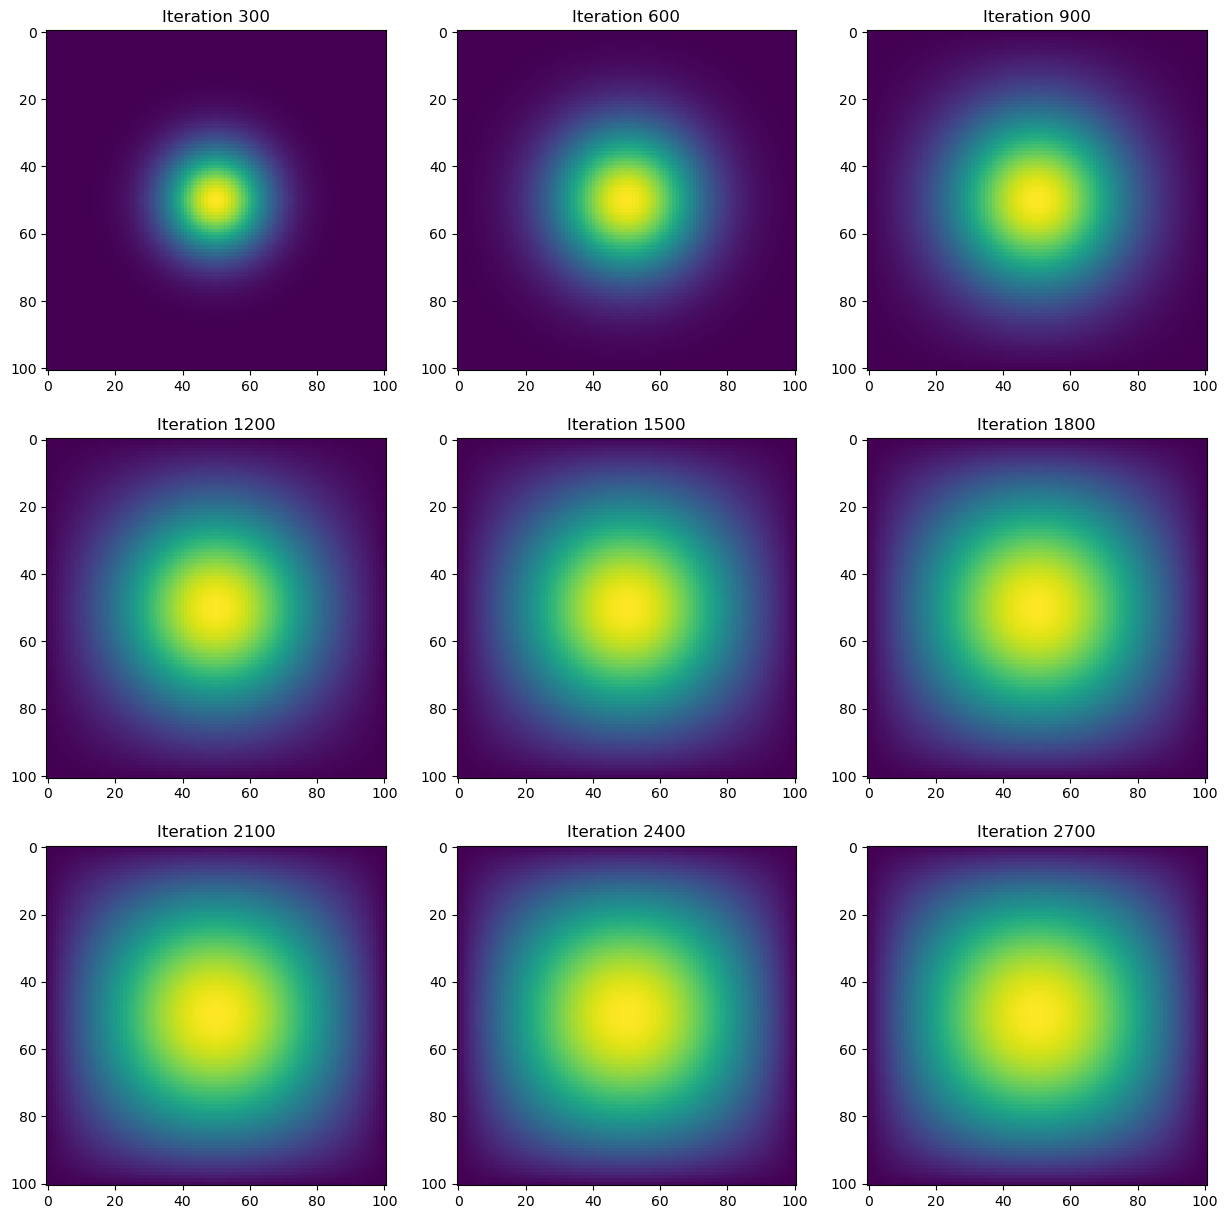

In [29]:
def sim_heat_diffusion_numpy(N, epsilon, iterations, interval):
    """Simulates heat diffusion using direct NumPy operations."""

    u = get_init_condition(N)

    sims = []

    start_time = time.time()
    
    for i in range(1, iterations + 1):
        u = advance_time_numpy(u, epsilon)
        
        if i % interval == 0:
            sims.append(u.copy())
    
    end_time = time.time()
    comp_time = end_time - start_time
    print(f"{comp_time:.2f} seconds for {iterations} iterations")
    
    return comp_time, sims

time_numpy, sims_numpy = sim_heat_diffusion_numpy(N, epsilon, iterations, interval)
vis_sim(sims_numpy)

Marvelous! This time, it's even faster. This approach is also more intuitive than the matrix-based ones. The performance is excellent since `numpy`'s vectorized operations are highly optimized.

### With `jax`

Finally, we can combine the direct array operations of Method 3 with the JIT compilation capabilities of JAX.

Would this be even faster?

In [33]:
print(inspect.getsource(advance_time_jax))

@jax.jit
def advance_time_jax(u, epsilon):
    """Advances the simulation by one timestep using JAX with JIT compilation.
    Args:
        u: N x N grid state at timestep k.
        epsilon: Stability constant.
        
    Returns:
        N x N Grid state at timestep k+1.
    """
    u_down = jnp.roll(u, -1, axis=0)
    u_up = jnp.roll(u, 1, axis=0)
    u_right = jnp.roll(u, -1, axis=1)
    u_left = jnp.roll(u, 1, axis=1)
    
    # Apply zero boundary conditions
    u_down = u_down.at[-1, :].set(0)
    u_up = u_up.at[0, :].set(0)
    u_right = u_right.at[:, -1].set(0)
    u_left = u_left.at[:, 0].set(0)
    
    u_new = u + epsilon * (
        u_down +
        u_up +
        u_right +
        u_left -
        4 * u
    )
    
    return u_new



0.07 seconds for 2700 iterations


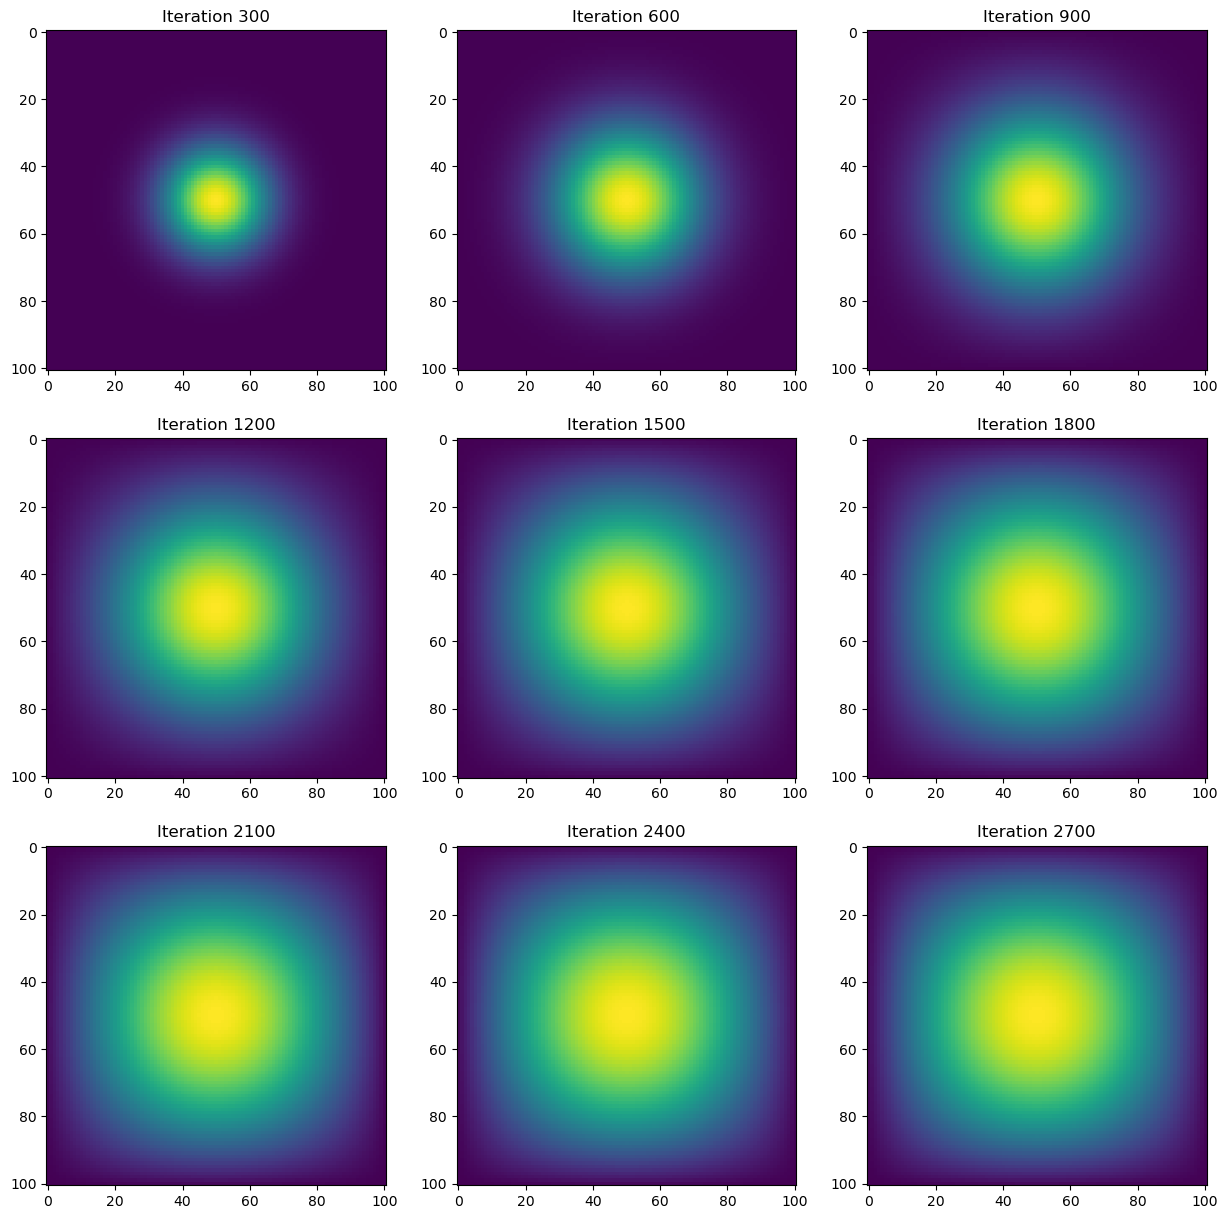

In [34]:
def sim_heat_diffusion_jax(N, epsilon, iterations,interval):
    """Simulates heat diffusion using JAX with JIT compilation."""

    u = get_init_condition(N)

    u_jax = jnp.array(u)
    
    u_jax = advance_time_jax(u_jax, epsilon)

    sims = []

    start_time = time.time()
    
    for i in range(1, iterations + 1):
        u_jax = advance_time_jax(u_jax, epsilon)
        
        if i % interval == 0:
            sims.append(np.array(u_jax))
    
    end_time = time.time()
    comp_time = end_time - start_time
    print(f"{comp_time:.2f} seconds for {iterations} iterations")
    
    return comp_time, sims

time_jax, sims_jax = sim_heat_diffusion_jax(N, epsilon, iterations,interval)
vis_sim(sims_jax)

The JAX implementation is almost as twice as fast as the previous approach! So far, this is the most elegant simulation. It combines the simplicity and intuitiveness of the third approach with the optimization of the second.

## Discussion

Now, we can compare the performance of all four methods by visualizing it in a table using `pandas`:

In [38]:
times = {
    "Matrix Multiplication": time_matvecmul,
    "Sparse Matrix": time_sparse,
    "NumPy Operations": time_numpy,
    "JAX JIT": time_jax
}

slowest = max(times, key=times.get)

# Create a table to compare the times
df = pd.DataFrame({
    'Method': list(times.keys()),
    'Time (s)': list(times.values()),
    'Relative Speed': [times[slowest]/time for time in times.values()]
})
display(df)

,Method,Time (s),Relative Speed
0,Matrix Multiplication,20.108428,1.000000
1,Sparse Matrix,0.757600,26.542273
2,NumPy Operations,0.129419,155.374801
3,JAX JIT,0.065926,305.015894


In all four methods, we have simulated the same physical process: starting with a single point of heat at the center of our grid and observing how it spreads outward over time. But their performance has drastic difference! From the table, we can infer that:

* **Matrix-vector multiplication** is the slowest; as mentioned before, this is primarily due to many unnecessary operations on zeros.
* The **sparse matrix** approach is much faster than the first method since its data structure avoids redundant computations.
* **Array operations using `numpy`** are both highly efficient and intuitive to implement, as they eliminate the need for matrices entirely.
* The **JAX JIT** method is the fastest among the four. It is also relatively easy to write after engaging with the previous approaches.

Great! In this tutorial, we've observed how a single mathematical problem can be solved in so many ways, with totally different—and sometimes surprising—performance outcomes. We've discovered that JAX JIT attains the best performance by combining direct operations with compilation optimization.

With these lessons in hand, we're now in good shape to tackle other scientific computing challenges, choosing the right method to best fulfill our research goals!